In [1]:
import warnings
from collections import Counter
import IPython
from IPython.core.display import display
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *
from tqdm import tqdm

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

# A. Load data, preprocess, and calculate accuracy

In [2]:
X, y, le = read_data(dataset)

In [3]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#keep train alone and test alone for create excel file in code
#further in the code
X_train_data = X_train
X_test_data = X_test
y_train_data = y_train
y_test_data= y_test
# will used it after/before training

#print(X_train_data[0])

#X_train_data

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# B. Plot confidence scores for all the data

In [4]:
#putted in comment the line below, so X_train will not be the whole data
#X_train, y_train = X, y
#clf.fit(X_train, y_train)
#the comment above was allready calc one cell before
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores
print("y_conf_train\n")
#print(y_conf_train)

y_conf_train



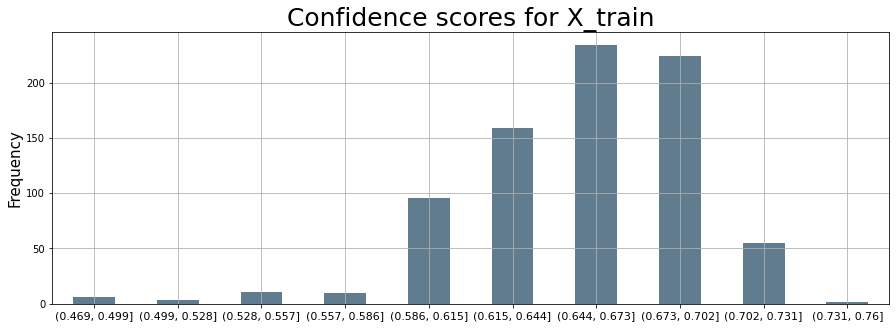

In [5]:
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Select C as the middle of top intervals

In [6]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values
#print(idxs[0])
#print(idxs.contains(0.6)[0])
print(freqs)
freqsSum = freqs.sum()
print(freqsSum)


# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

[  6   3  11  10  96 159 234 224  55   2]
800


In [7]:
top_c_lst

[0.484, 0.5135, 0.5425, 0.5715, 0.6005, 0.6295, 0.6585, 0.6875, 0.7165, 0.7455]

# D. Train one CTGAN with middle of intervals (10 Confidence levels)

In [9]:

# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all
X_train_pd = pd.DataFrame(X_train)



# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
#confidence_level = c
gen_lr = 2e-5
loss = 'log'

#now ctgan synthesizer gets conf levels as input
rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )
#print(rf_ctgan.confidence_levels)

print(f"Training CTGAN for c list = {top_c_lst} ...")
#removed conf level from fit input arguements
allconf_levels_hist = rf_ctgan.fit(train_data=z,
                                   epochs=epochs,
                                   gen_lr=gen_lr,
                                   verbose=False
                                  )

#print("\nhistory of all confidence levels:\n")
#print(allconf_levels_hist)
#print("\n\n")
# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()

#allsamplesInv = 0
#allDataFrames = []
#allgeninv= 0
alldataframescoverage =[]
alldataframesprecision =[]
freqsCounter = 0
#add here conf loop, send each conf to samples as input each loop
for c in top_c_lst:
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples,c)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores


    # ans is the indices of gen_data to make the same dist
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]

    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    gen_data_inv = pd.DataFrame(gen_data_inv)

    #calc all inv
    #freqs[freqsCounter] probably in our the gen size data train
    # in the interval bin that c in it
    #allgeninv = allgeninv + freqs[freqsCounter]
    #calc end

    # y_conf_gen_same_dist, gen_data_inv what we want
    # results
    # E. Calculate coverage for each similarity and conf diff thresholds

    #sum all geninvsamples
    #allsamplesInv =allsamplesInv + gen_data_inv.size()

    print(f"\tWorking on results...")
    results,coverage, precision = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)

    print("datagen inv size:")
    print(gen_data_inv.size)
    print("\n")
    print("current bin size:")
    print(freqs[freqsCounter])
    print("\n")

    #keep all data frames
    alldataframescoverage.append([coverage,freqs[freqsCounter]])
    alldataframesprecision.append([precision,freqs[freqsCounter]])
   # allDataFrames.append(results)

    print(f"\tResults for confidence level = {c}")
    display(results)
    freqsCounter=freqsCounter+1




#print("allgen in size")
#print(allgeninv)
#print("\n")
print("all bins size")
print(freqsSum)
print("\n")

print("calculate weighted average results\n")
a= alldataframescoverage[0][0] *0
#display(a)
for index in range(len(alldataframescoverage)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    a= a+ alldataframescoverage[index][0]*alldataframescoverage[index][1]
a = a/freqsSum
#display weighted averaged coverage
display(a)


b= alldataframesprecision[0][0] *0
#display(b)
for index in range(len(alldataframesprecision)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    b= b+ alldataframesprecision[index][0]*alldataframesprecision[index][1]
b = b/freqsSum
#display weighted averaged precision
display(b)

a = a.astype(str)
b = b.astype(str)

result_weighted_Average = a+" | "+b

print("result_weighted_Average:\n")
display(result_weighted_Average)



Training CTGAN for c list = [0.484, 0.5135, 0.5425, 0.5715, 0.6005, 0.6295, 0.6585, 0.6875, 0.7165, 0.7455] ...
	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
6


	Results for confidence level = 0.484


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.875,100.0 | 97.5,100.0 | 97.75,100.0 | 97.75,100.0 | 97.75
0.85,100.0 | 95.625,100.0 | 96.0,100.0 | 96.125,100.0 | 96.125,100.0 | 96.125
0.90,100.0 | 93.75,100.0 | 94.5,100.0 | 94.625,100.0 | 94.75,100.0 | 94.75
0.95,95.75 | 88.75,100.0 | 89.625,100.0 | 90.75,100.0 | 90.875,100.0 | 90.875
0.99,59.5 | 59.875,81.875 | 72.75,83.875 | 75.5,83.875 | 75.75,84.0 | 75.75


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
3


	Results for confidence level = 0.5135


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 98.125,100.0 | 98.375,100.0 | 98.375,100.0 | 98.375,100.0 | 98.375
0.85,100.0 | 97.125,100.0 | 97.75,100.0 | 97.75,100.0 | 97.75,100.0 | 97.75
0.90,100.0 | 95.125,100.0 | 95.375,100.0 | 95.5,100.0 | 95.5,100.0 | 95.5
0.95,98.375 | 90.875,100.0 | 92.125,100.0 | 92.125,100.0 | 92.125,100.0 | 92.125
0.99,57.0 | 72.125,73.25 | 78.125,77.0 | 78.5,77.0 | 78.5,77.0 | 78.5


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
11


	Results for confidence level = 0.5425


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.625,100.0 | 98.125,100.0 | 98.125,100.0 | 98.125,100.0 | 98.125
0.85,100.0 | 95.875,100.0 | 97.375,100.0 | 97.75,100.0 | 97.75,100.0 | 97.75
0.90,100.0 | 93.875,100.0 | 95.25,100.0 | 95.875,100.0 | 95.875,100.0 | 95.875
0.95,94.375 | 88.125,98.625 | 91.0,100.0 | 91.875,100.0 | 91.875,100.0 | 91.875
0.99,54.125 | 62.0,69.375 | 77.0,72.0 | 79.875,75.0 | 80.0,75.0 | 80.0


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
10


	Results for confidence level = 0.5715


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 95.375,100.0 | 97.5,100.0 | 97.625,100.0 | 97.625,100.0 | 97.625
0.85,100.0 | 93.875,100.0 | 96.0,100.0 | 96.5,100.0 | 96.5,100.0 | 96.5
0.90,100.0 | 90.5,100.0 | 93.625,100.0 | 94.25,100.0 | 94.375,100.0 | 94.375
0.95,90.25 | 84.875,100.0 | 89.125,100.0 | 89.75,100.0 | 89.75,100.0 | 89.75
0.99,48.5 | 63.875,72.375 | 72.0,77.75 | 76.0,79.125 | 76.625,79.125 | 76.625


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
96


	Results for confidence level = 0.6005


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.75,100.0 | 98.0,100.0 | 98.0,100.0 | 98.0,100.0 | 98.0
0.85,100.0 | 94.75,100.0 | 97.5,100.0 | 97.5,100.0 | 97.5,100.0 | 97.5
0.90,100.0 | 91.25,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0
0.95,99.625 | 84.125,100.0 | 90.75,100.0 | 90.875,100.0 | 90.875,100.0 | 90.875
0.99,61.75 | 64.125,76.5 | 75.375,79.0 | 76.0,79.25 | 76.375,80.0 | 76.375


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
159


	Results for confidence level = 0.6295


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.0,100.0 | 98.0,100.0 | 98.0,100.0 | 98.0,100.0 | 98.0
0.85,100.0 | 96.125,100.0 | 96.875,100.0 | 96.875,100.0 | 96.875,100.0 | 96.875
0.90,100.0 | 93.375,100.0 | 95.25,100.0 | 95.25,100.0 | 95.25,100.0 | 95.25
0.95,95.25 | 87.125,99.75 | 90.625,99.75 | 90.625,99.75 | 90.625,99.75 | 90.625
0.99,59.875 | 66.125,70.125 | 77.25,71.5 | 77.75,71.5 | 77.75,72.5 | 77.75


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
234


	Results for confidence level = 0.6585


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.5,100.0 | 96.75,100.0 | 97.75,100.0 | 97.75,100.0 | 97.75
0.85,100.0 | 93.625,100.0 | 94.75,100.0 | 96.375,100.0 | 96.375,100.0 | 96.375
0.90,100.0 | 90.875,100.0 | 91.75,100.0 | 93.625,100.0 | 93.625,100.0 | 93.625
0.95,91.25 | 85.0,100.0 | 86.0,100.0 | 89.375,100.0 | 89.375,100.0 | 89.375
0.99,43.625 | 65.375,77.375 | 74.375,83.125 | 77.125,83.875 | 77.75,83.875 | 77.75


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
224


	Results for confidence level = 0.6875


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.75,100.0 | 97.75,100.0 | 98.25,100.0 | 98.25,100.0 | 98.25
0.85,100.0 | 94.5,100.0 | 96.625,100.0 | 97.25,100.0 | 97.25,100.0 | 97.25
0.90,100.0 | 92.125,100.0 | 95.0,100.0 | 95.625,100.0 | 95.625,100.0 | 95.625
0.95,94.875 | 86.125,100.0 | 91.625,100.0 | 92.625,100.0 | 92.625,100.0 | 92.625
0.99,52.125 | 66.0,73.875 | 76.5,79.5 | 79.875,79.75 | 79.875,79.875 | 80.0


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
55


	Results for confidence level = 0.7165


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 94.625,100.0 | 95.875,100.0 | 97.25,100.0 | 97.25,100.0 | 97.25
0.85,100.0 | 93.125,100.0 | 93.875,100.0 | 95.5,100.0 | 95.5,100.0 | 95.5
0.90,99.875 | 90.75,100.0 | 92.375,100.0 | 93.625,100.0 | 93.625,100.0 | 93.625
0.95,88.125 | 85.0,100.0 | 87.625,100.0 | 90.0,100.0 | 90.125,100.0 | 90.125
0.99,50.0 | 68.875,69.875 | 73.5,77.25 | 76.25,77.375 | 76.625,77.375 | 76.625


	Generate samples to same dist...
	Working on results...
datagen inv size:
19200


current bin size:
2


	Results for confidence level = 0.7455


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.125,100.0 | 98.375,100.0 | 98.625,100.0 | 98.625,100.0 | 98.625
0.85,100.0 | 95.25,100.0 | 97.375,100.0 | 97.375,100.0 | 97.375,100.0 | 97.375
0.90,100.0 | 91.875,100.0 | 93.875,100.0 | 94.375,100.0 | 94.375,100.0 | 94.375
0.95,99.75 | 87.25,100.0 | 89.375,100.0 | 90.25,100.0 | 90.25,100.0 | 90.25
0.99,54.0 | 61.0,70.25 | 75.25,74.25 | 77.125,75.125 | 77.125,75.125 | 77.125


all bins size
800


calculate weighted average results



,0.01,0.05,0.10,0.15,0.20
0.80,100.000000,100.000000,100.000000,100.000000,100.000000
0.85,100.000000,100.000000,100.000000,100.000000,100.000000
0.90,99.991406,100.000000,100.000000,100.000000,100.000000
0.95,93.962344,99.931406,99.950312,99.950312,99.950312
0.99,52.248438,74.161406,78.640938,79.029531,79.354219


,0.01,0.05,0.10,0.15,0.20
0.80,96.582344,97.412344,97.943438,97.943438,97.943438
0.85,94.533750,96.046094,96.820469,96.820469,96.820469
0.90,91.834844,94.019688,94.848125,94.850625,94.850625
0.95,85.729531,89.342344,90.818281,90.827812,90.827812
0.99,65.697656,75.611719,77.840781,78.105781,78.140781


result_weighted_Average:



,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.58234375,100.0 | 97.41234375,100.0 | 97.9434375,100.0 | 97.9434375,100.0 | 97.9434375
0.85,100.0 | 94.53375,100.0 | 96.04609375,100.0 | 96.82046875,100.0 | 96.82046875,100.0 | 96.82046875
0.90,99.99140625 | 91.83484375,100.0 | 94.0196875,100.0 | 94.848125,100.0 | 94.850625,100.0 | 94.850625
0.95,93.96234375 | 85.72953125,99.93140625 | 89.34234375,99.9503125 | 90.81828125,99.9503125 | 90.8278125,99.9503125 | 90.8278125
0.99,52.2484375 | 65.69765625,74.16140625 | 75.61171875,78.6409375 | 77.84078125,79.02953125 | 78.10578125,79.35421875 | 78.14078125


In [9]:
"""
import xlsxwriter
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#create excel file
workbook = xlsxwriter.Workbook('German_confidences.xlsx')




#keeps train and test seperatly
#clf.fit(X_train_data, y_train_data)
#y_prob_train_data = rf.predict_proba(X_train_data)
y_conf_train_data = y_conf_train  # confidence scores
print("y_conf_train_data\n")

#clf.fit(X_test_data, y_test_data)
y_prob_test_data = rf.predict_proba(X_test_data)
y_conf_test_data = y_prob_test_data[:, 0]  # confidence scores
print("y_conf_test_data\n")
#print(y_conf_train)
#keeped



# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all
X_train_pd = pd.DataFrame(X_train)



# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
#confidence_level = c
gen_lr = 2e-5
loss = 'log'

#now ctgan synthesizer gets conf levels as input
rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )
#print(rf_ctgan.confidence_levels)

print(f"Training CTGAN for c list = {top_c_lst} ...")
#removed conf level from fit input arguements
allconf_levels_hist = rf_ctgan.fit(train_data=z,
                                   epochs=epochs,
                                   gen_lr=gen_lr,
                                   verbose=False
                                  )

#print("\nhistory of all confidence levels:\n")
#print(allconf_levels_hist)
#print("\n\n")
# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()

#allsamplesInv = 0
#allDataFrames = []
#allgeninv= 0
#alldataframescoverage =[]
#alldataframesprecision =[]
freqsCounter = 0
#add here conf loop, send each conf to samples as input each loop

#to delete
#c= top_c_lst[0]
#top_c_lst = [c]
#delete above
for c in top_c_lst:
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples,c)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores


    # ans is the indices of gen_data to make the same dist
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]

    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    #gen_data_inv = pd.DataFrame(gen_data_inv)

    #find kmean to geninv ndarray
    kmeans = KMeans(n_clusters=1).fit(gen_data_inv)
    gen_data_inv_centroide = kmeans.cluster_centers_

    #create new worksheet, excel for bin Contains Conf c
    name ="bin Contains Conf "+str(c)
    worksheet = workbook.add_worksheet(name)

    #create columns name of excel worksheet
    worksheet.write('A1', 'TR/TS_index')
    worksheet.write('B1', 'train/test')
    worksheet.write('C1', 'cosin_similarity')

    #fill the current worksheet excel
    row =1
    col = 0
    #isTrain= True
    #j=0
    # Iterate over the data and write it out row by row.
    #train_counter = 0
    #print(x_train_data[0])
    #print(x_train_data[0].shape)
    #print(gen_data_inv_centroide)
    #print(gen_data_inv_centroide.shape)
    for sample_idx, sample_conf in enumerate (y_conf_train_data):
        #if the conf of data is in the current interval
        #so we want to add it to the excel bin conf
        if(idxs.contains(sample_conf)[freqsCounter]):
            #print("train entered to excel\n")
            #down i reshaped to make the train data[freqcount]
            #to be in 2D as needed(was 1D) and 1 -1 to make it (1,24)
            csm = cosine_similarity(gen_data_inv_centroide, X_train_data[sample_idx].reshape(1,-1)).squeeze()
            #print(csm)
            #print(sample_idx)
            #print(row)
            #print(col)
            worksheet.write(row, col, sample_idx)
            worksheet.write(row, col + 1, 'train')
            worksheet.write(row, col + 2, csm)
           # isTrain = !isTrain
            row += 1
            #j+=1
            #train_counter+=1



    col = 0
    #isTrain= True
    #j=0
    # Iterate over the data and write it out row by row.
    #test_counter = 0
    #print(y_conf_train_data)
    #print(y_conf_test_data)

    for sample_idx, sample_conf in enumerate (y_conf_test_data):
        #print("in test loop\n")
        #if the conf of data is in the current interval bin
        #so we want to add it to the excel bin conf
        if(idxs.contains(sample_conf)[freqsCounter]):
            #print("test entered to excel\n")
            csm = cosine_similarity(gen_data_inv_centroide, X_test_data[sample_idx].reshape(1,-1)).squeeze()
            worksheet.write(row, col, sample_idx)
            worksheet.write(row, col + 1, 'test')
            worksheet.write(row, col + 2, csm)
           # isTrain = !isTrain
            row += 1
            #j+=1
            #test_counter+=1



    freqsCounter=freqsCounter+1

workbook.close()

    #calcute and create excel

"""

y_conf_train_data

y_conf_test_data

Training CTGAN for c list = [0.484, 0.5135, 0.5425, 0.5715, 0.6005, 0.6295, 0.6585, 0.6875, 0.7165, 0.7455] ...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
	Generate samples to same dist...
